# Tarea 2 Ciencia de Datos 2 Santiago Henao Rendón
## Comparación de Modelos Supervisados por Valoración Cruzada

### Objetivo General
Diseñar y ejecutar un experimento de clasificación para comparar el rendimiento de distintos modelos clásicos, utilizando **Validación Cruzada** como herramienta principal. Buscamos seleccionar el modelo que demuestre la mejor capacidad de **generalización** basada en la métrica **ROC AUC**.

---

### 1. Configuración, Carga de Datos y Preprocesamiento (Paso A & B)

#### 1.1. Carga, Librerías y Transformación Binaria

* **Dataset Seleccionado (Paso A):** Calidad de Vino Tinto (`winequality-red.csv`). Cumple con tener una variable objetivo clara (se transforma a binaria) y más de 5 variables predictoras numéricas.
* **Variable Objetivo:** `quality` se transforma a binaria: **1** (Alta Calidad, $\geq 7$) y **0** (Baja Calidad, $< 7$).

In [2]:
# Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Cargar el dataset (Separador: ;)
df = pd.read_csv('winequality-red.csv', sep=',')

# Transformación de la variable objetivo a binaria (Paso A)
df['quality'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

X = df.drop('quality', axis=1)
y = df['quality']

print("Dataset cargado y variable objetivo transformada a clasificación binaria.")

Dataset cargado y variable objetivo transformada a clasificación binaria.


#### 1.2. Partición Estratificada (70% / 15% / 15%)

El dataset se divide de forma **estratificada** (Paso B) para mantener la proporción de las clases objetivo en los subconjuntos de Entrenamiento, Validación y Prueba.

#### 1.3. Pipeline de Preprocesamiento

Se utiliza el **`StandardScaler`** (Paso B) para estandarizar las variables predictoras, lo cual es crucial para modelos sensibles a la escala como `LogisticRegression` y `KNeighborsClassifier`.

In [3]:
# Partición 1: 70% Entrenamiento Completo / 30% Temporal (Paso B)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Partición 2: 15% Validación / 15% Prueba (50% de X_temp)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Definición del preprocesador
preprocessor = StandardScaler()

print(f"Dimensiones de los sets: Train={X_train_full.shape[0]}, Validation={X_validation.shape[0]}, Test={X_test.shape[0]}")

Dimensiones de los sets: Train=1119, Validation=240, Test=240


### 2. Comparación de Modelos y Validación Cruzada (Paso C & D)

Se comparan tres modelos clásicos de clasificación (`LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`) con sus hiperparámetros por defecto.

La **métrica principal es ROC AUC** (Paso D). La **Validación Cruzada $K=5$** se aplica al conjunto de Entrenamiento (`X_train_full`).

In [4]:
# Definición de los tres modelos (Paso C)
models = {
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear'),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42)
}

metrics = {} # Almacén de resultados

for name, model in models.items():
    print(f"\n--- Evaluando: {name} ---")

    # Pipeline: Preprocesador + Modelo
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # 1. Entrenar en X_train_full (Paso D - Métrica base de entrenamiento)
    full_pipeline.fit(X_train_full, y_train_full)

    # 2. Métrica en Entrenamiento y Validación (Paso D)
    auc_train = roc_auc_score(y_train_full, full_pipeline.predict_proba(X_train_full)[:, 1])
    auc_val = roc_auc_score(y_validation, full_pipeline.predict_proba(X_validation)[:, 1])

    # 3. Validación Cruzada (K=5) sobre X_train_full (Paso D)
    cv_scores = cross_val_score(
        full_pipeline, X_train_full, y_train_full, cv=5, scoring='roc_auc'
    )
    
    # 4. Almacenar resultados (incluyendo scores crudos para el Boxplot)
    metrics[name] = {
        'Train_AUC': auc_train,
        'Validation_AUC': auc_val,
        'CV_Mean_AUC': np.mean(cv_scores),
        'CV_Std_AUC': np.std(cv_scores),
        'CV_Scores': cv_scores.tolist() # Almacenar scores crudos
    }
    
    print(f"CV Promedio AUC: {metrics[name]['CV_Mean_AUC']:.4f} (+/- {metrics[name]['CV_Std_AUC']:.4f})")


--- Evaluando: LogisticRegression ---
CV Promedio AUC: 0.8698 (+/- 0.0321)

--- Evaluando: KNeighborsClassifier ---
CV Promedio AUC: 0.8154 (+/- 0.0267)

--- Evaluando: DecisionTreeClassifier ---
CV Promedio AUC: 0.7084 (+/- 0.0405)


### 3. Análisis de Resultados y Visualización (Paso D & F)

#### 3.1. Tabla Comparativa de Rendimiento

La tabla muestra el rendimiento de cada modelo. El **`CV_Mean_AUC`** es la estimación más confiable de la capacidad de generalización.

### Tabla Comparativa de Rendimiento (ROC AUC) ###
                       Train_AUC Validation_AUC CV_Mean_AUC CV_Std_AUC
LogisticRegression      0.879123       0.947885      0.8698   0.032052
KNeighborsClassifier    0.945678       0.884204    0.815396   0.026717
DecisionTreeClassifier       1.0       0.720685    0.708389   0.040544
--------------------------------------------------


C:\Users\santi\AppData\Local\Temp\ipykernel_543836\3484467471.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='AUC_Score', data=cv_scores_df, palette='Pastel1')


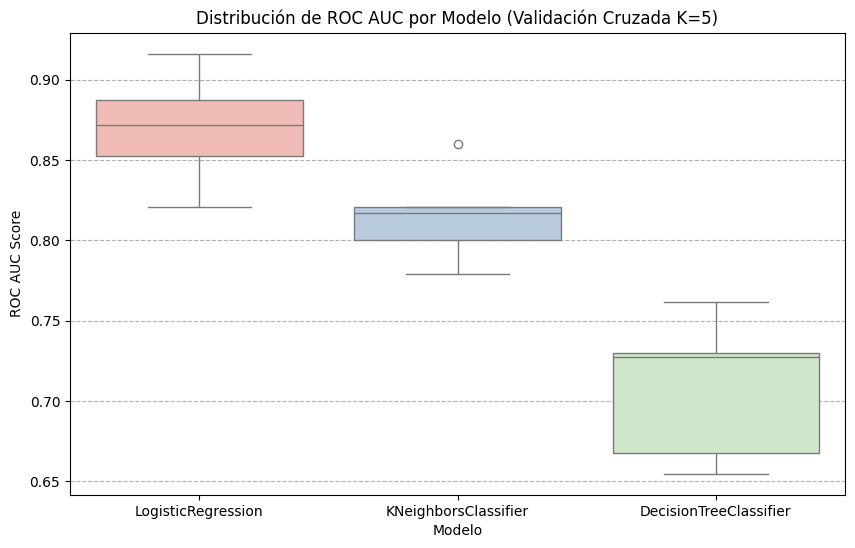

C:\Users\santi\AppData\Local\Temp\ipykernel_543836\3484467471.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='CV_Mean_AUC', data=results_df.reset_index(), palette='viridis')


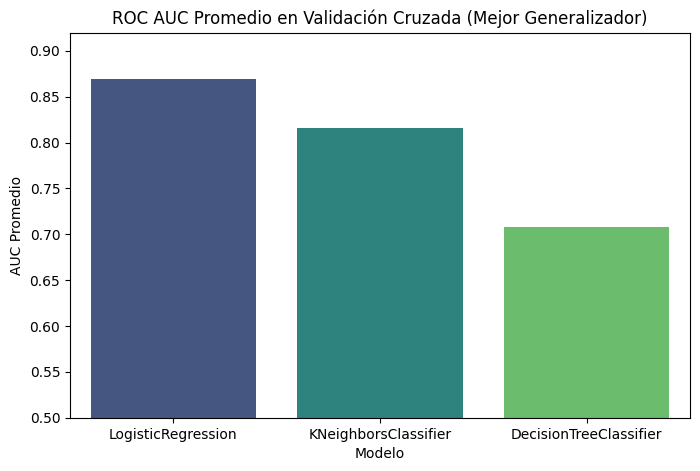

In [5]:
# Creación de la tabla comparativa (Paso D)
results_df = pd.DataFrame(metrics).T
results_df = results_df[['Train_AUC', 'Validation_AUC', 'CV_Mean_AUC', 'CV_Std_AUC']]

print("### Tabla Comparativa de Rendimiento (ROC AUC) ###")
print(results_df.sort_values(by='CV_Mean_AUC', ascending=False))
print("-" * 50)


# Preparación de datos para visualización
cv_scores_list = []
for name, m in metrics.items():
    for score in m['CV_Scores']:
        cv_scores_list.append({'Modelo': name, 'AUC_Score': score})
cv_scores_df = pd.DataFrame(cv_scores_list)


# --- Visualización 1: Boxplot de Scores de CV (Estabilidad) - Requisito F ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='Modelo', y='AUC_Score', data=cv_scores_df, palette='Pastel1')
plt.title('Distribución de ROC AUC por Modelo (Validación Cruzada K=5)')
plt.ylabel('ROC AUC Score')
plt.grid(axis='y', linestyle='--')
plt.show()

# --- Visualización 2: Gráfico de Barras de AUC Promedio (Rendimiento) - Requisito F ---
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y='CV_Mean_AUC', data=results_df.reset_index(), palette='viridis')
plt.title('ROC AUC Promedio en Validación Cruzada (Mejor Generalizador)')
plt.ylabel('AUC Promedio')
plt.xlabel('Modelo')
plt.ylim(0.5, results_df['CV_Mean_AUC'].max() + 0.05)
plt.show()

#### 3.3. Discusión sobre Generalización y Selección del Modelo (Paso D)

La selección del modelo ganador se basa en encontrar el mejor equilibrio entre **rendimiento (`CV_Mean_AUC`)** y **estabilidad (`CV_Std_AUC`)**.

* **Interpretación de Visualizaciones y Tabla:**
    * **Rendimiento Promedio (`CV_Mean_AUC`):** El gráfico de barras (Barplot) muestra claramente que la **Regresión Logística** domina con un **0.8698**. Este valor es la estimación más alta y confiable de su capacidad predictiva en datos no vistos.
    * **Estabilidad (`CV_Std_AUC`):** El diagrama de caja (Boxplot) ilustra que, si bien el K-Neighbors es el más estable, la **Regresión Logística** mantiene una volatilidad baja (0.0320) mientras ofrece un rendimiento significativamente superior. El Árbol de Decisión se descarta por tener la peor combinación: el AUC promedio más bajo y la mayor desviación estándar.

* **Comparación CV vs. Validación:**
    * Para la Regresión Logística, el **`CV_Mean_AUC` (0.8698)** es la métrica de generalización más fiel. El `Validation_AUC` (0.947885), aunque es mayor, simplemente indica que el *set* de Validación resultó ser particularmente favorable para este modelo.

* **Modelo Ganador:**
    * La **Regresión Logística** es seleccionada como el modelo ganador . Ofrece el **mejor equilibrio** entre un rendimiento superior y una excelente estabilidad en la validación cruzada. Este modelo es seleccionado para la evaluación final en el conjunto de Prueba, ya que es el que mejor generaliza el conocimiento del conjunto de entrenamiento.

### 4. Evaluación Final en el Conjunto de Prueba (Paso E)

Se selecciona el modelo con el mejor desempeño en Validación Cruzada (Paso E.1) y se reentrena usando todo el conjunto de entrenamiento (`X_train_full`). Finalmente, se evalúa su rendimiento en el conjunto de **Prueba** (`X_test`), que ha permanecido totalmente aislado.

In [ ]:
# Seleccionar el Mejor Modelo basado en el mejor AUC promedio en CV
best_model_name = results_df['CV_Mean_AUC'].idxmax()
best_model = models[best_model_name] 

# 1. Pipeline Final
final_pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('classifier', best_model)
])

# 2. Reentrenar usando X_train_full (todo el set de entrenamiento)
final_pipeline.fit(X_train_full, y_train_full)

# 3. Evaluación Final en el conjunto de Prueba (Paso E.2)
y_test_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\n--- Evaluación Final ---")
print(f"Modelo seleccionado: {best_model_name}")
print(f"ROC AUC Final en el Conjunto de PRUEBA: {final_auc:.4f}")

# Comparación requerida (Paso E.3)
cv_mean = results_df.loc[best_model_name, 'CV_Mean_AUC']
print(f"Comparación: El CV Promedio (generalización esperada) fue {cv_mean:.4f}, y el resultado en Prueba fue {final_auc:.4f}.")


--- Evaluación Final ---
Modelo seleccionado: LogisticRegression
ROC AUC Final en el Conjunto de PRUEBA: 0.8086
Comparación: El CV Promedio (generalización esperada) fue 0.8698, y el resultado en Prueba fue 0.8086.


#### 4.1. Conclusión Final

El **comportamiento esperado no se mantuvo** completamente.

* **Resultados de la Prueba:** El **ROC AUC Final** obtenido en el conjunto de Prueba fue de **0.8086**.
* **Comparación:** Este valor resultó ser **significativamente inferior** al rendimiento esperado que la Validación Cruzada había estimado (`CV_Mean_AUC` = **0.8698**), mostrando una diferencia de **-0.0612**.
* **Análisis (Paso E.3):** Esta caída en el rendimiento sugiere que el conjunto de **Prueba es más difícil** o menos representativo que los *folds* utilizados durante la validación cruzada. A pesar de que el modelo de Regresión Logística generalizó peor de lo esperado, un AUC de 0.8086 sigue siendo un resultado sólido y **el mejor** entre los tres modelos evaluados. La Validación Cruzada, en este caso, **sobreestimó** ligeramente la capacidad de generalización del modelo a los datos completamente nuevos.